In [53]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt

from scipy.special import loggamma, logsumexp
from scipy.optimize import minimize_scalar, minimize, differential_evolution
from scipy.stats import gamma, beta, lognorm

In [54]:
path = r"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\simulated_data\500c50m"
alphas = []
betas = []
vafs_H = []
vafs_R = []
vafs_A = []
dropouts = []
dropout_directions = []

for i in range(100):
    alt = np.loadtxt(os.path.join(path, "alt", 'alt_%i.txt' % i)).T
    ref = np.loadtxt(os.path.join(path, "ref", 'ref_%i.txt' % i)).T
    genotype_gt = np.loadtxt((os.path.join(path, "genotype", "genotype_%i.txt" % i)), dtype = str).T
    dropout_probs_gt = np.loadtxt((os.path.join(path, "dropout_probs", "dropout_probs_%i.txt" % i)))
    dropout_directions_gt = np.loadtxt((os.path.join(path, "dropout_directions", "dropout_directions_%i.txt" % i)))
    alphas_H_gt = np.loadtxt((os.path.join(path, "alphas_H", "alphas_H_%i.txt" % i)))
    betas_H_gt = np.loadtxt((os.path.join(path, "betas_H", "betas_H_%i.txt" % i)))
    
    alphas.extend(alphas_H_gt.tolist())
    betas.extend(betas_H_gt.tolist())
    dropouts.extend(dropout_probs_gt.astype(float).tolist())
    dropout_directions.extend(dropout_directions_gt.astype(float).tolist())
    
    total = alt + ref
    with np.errstate(divide='ignore', invalid='ignore'):
        vaf = np.where(total > 0, alt / total, np.nan)

    # Flatten arrays to iterate over all cells/SNVs in the file
    vaf_flat = vaf.flatten()
    genotype_flat = genotype_gt.flatten()
    
    # Select VAFs for each genotype
    vafs_H.extend(vaf_flat[genotype_flat == 'H'])
    vafs_R.extend(vaf_flat[genotype_flat == 'R'])
    vafs_A.extend(vaf_flat[genotype_flat == 'A'])

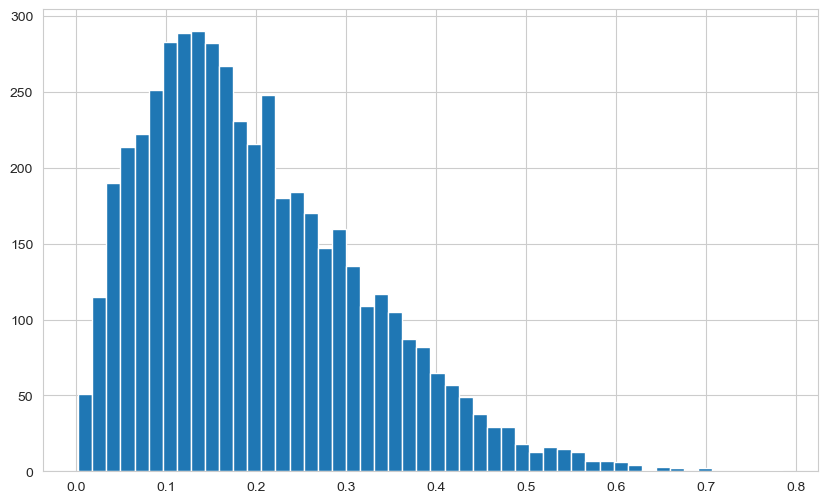

In [55]:
plt.figure(figsize=(10, 6))
plt.hist(dropouts, bins=50)
plt.show()

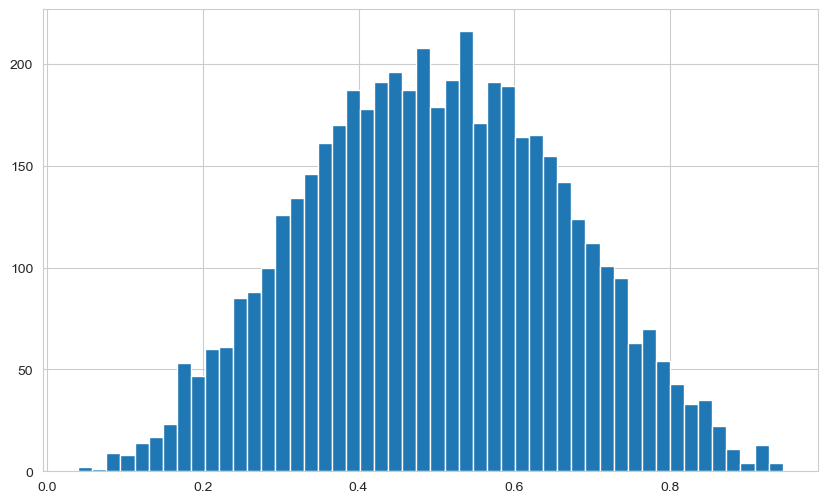

In [56]:
plt.figure(figsize=(10, 6))
plt.hist(dropout_directions, bins=50)
plt.show()

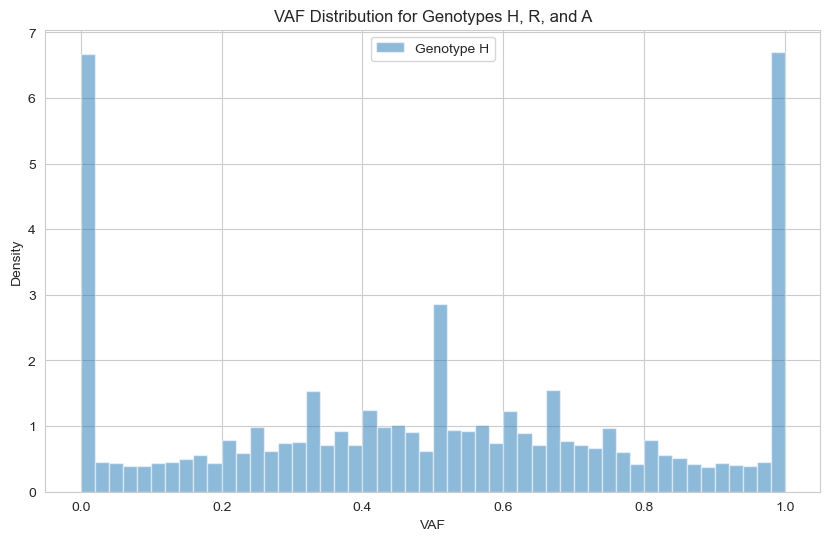

In [57]:
plt.figure(figsize=(10, 6))
plt.hist(vafs_H, bins=50, alpha=0.5, label='Genotype H', density=True)
# plt.hist(vafs_R, bins=50, alpha=0.5, label='Genotype R', density=True)
# plt.hist(vafs_A, bins=50, alpha=0.5, label='Genotype A', density=True)

plt.xlabel('VAF')
plt.ylabel('Density')
plt.title('VAF Distribution for Genotypes H, R, and A')
plt.legend()
plt.show()
# The spikes are artifacts of the low coverage

In [58]:
print(np.max(alphas), np.max(betas))

10.972851336380273 10.972851336380273


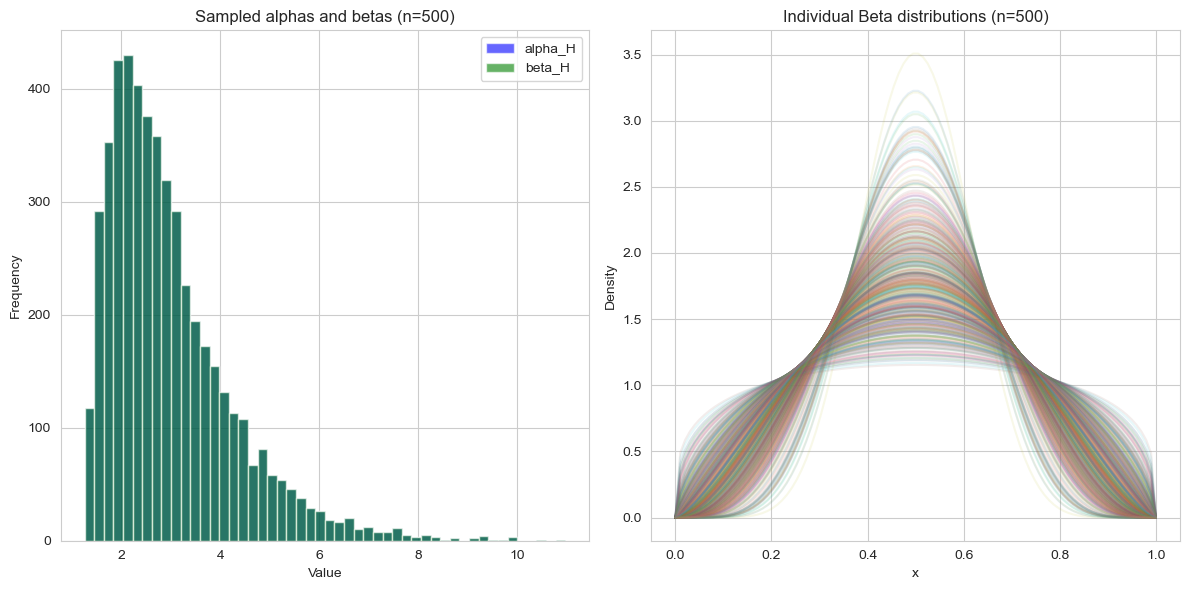

In [59]:
n_samples = 500  # reduced to make individual plots readable
x = np.linspace(0, 1, 100)  # Beta distribution is defined on [0, 1]

plt.figure(figsize=(12, 6))

# Plot the alphas and betas histograms (left plot)
plt.subplot(1, 2, 1)
plt.hist(alphas, bins=50, alpha=0.6, color='blue', label='alpha_H')
plt.hist(betas, bins=50, alpha=0.6, color='green', label='beta_H')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.title(f'Sampled alphas and betas (n={n_samples})')
plt.grid(True)

# Plot individual Beta distributions (right plot)
plt.subplot(1, 2, 2)
for i in range(n_samples):
    plt.plot(x, beta.pdf(x, alphas[i], betas[i]), alpha=0.1)

plt.xlabel('x')
plt.ylabel('Density')
plt.title(f'Individual Beta distributions (n={n_samples})')
plt.grid(True)

plt.tight_layout()
plt.show()

In [60]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# Choose a file index to load
i = 0

# Load the data:
# alt and ref are assumed to be cells x SNVs
alt = np.loadtxt(os.path.join(path, "alt", f'alt_{i}.txt')).T
ref = np.loadtxt(os.path.join(path, "ref", f'ref_{i}.txt')).T
genotype_gt = np.loadtxt(os.path.join(path, "genotype", f'genotype_{i}.txt'),
                         dtype=str).T
genotype = np.loadtxt(r"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\simulated_data\500c50m/genotype.txt", dtype=str)

# Ground truth Beta parameters for heterozygous (H) sites.
# These are 1D arrays of length equal to the number of SNVs.
alphas_H_gt = np.loadtxt(os.path.join(path, "alphas_H", f'alphas_H_{i}.txt'))
betas_H_gt  = np.loadtxt(os.path.join(path, "betas_H", f'betas_H_{i}.txt'))
dropout_probs_gt = np.loadtxt((os.path.join(path, "dropout_probs", "dropout_probs_%i.txt" % i)))
dropout_directions_gt = np.loadtxt((os.path.join(path, "dropout_directions", "dropout_directions_%i.txt" % i)))

In [61]:
np.sum(genotype_gt != genotype)

1484

In [64]:
def ln_gamma(z):
    return math.lgamma(z)

def betaln(x, y):
    return ln_gamma(x) + ln_gamma(y) - ln_gamma(x + y)

def factorial(n):
    if n == 0 or n == 1:
        return 0.0  # log(1) = 0, log(0) is undefined, return 0.0 as safe placeholder
    result = 0.0
    for i in range(2, n + 1):
        result += np.log(i)
    return result


def logbinom(n, k):
    return loggamma(n + 1) - loggamma(k + 1) - loggamma(n - k + 1)


def lognormalize(array):
    return array - logsumexp(array)

def log_binomial_coefficient(n, k):
    if 0 <= k <= n:
        log_numerator = factorial(n)
        log_denominator = factorial(k) + factorial(n - k)
        return log_numerator - log_denominator
    else:
        return 0.0  # Return 0.0 for invalid inputs


def betabinom_pmf(k, n, a, b):
    if n < 0 or k < 0 or k > n or a <= 0 or b <= 0:
        return 0.0

    log_binom_coef = log_binomial_coefficient(n, k)

    num = betaln(k + a, n - k + b)
    denom = betaln(a, b)

    return np.exp(num - denom + log_binom_coef)
def calculate_heterozygous_log_likelihoods(k, n, dropout_prob, dropout_direction_prob, alpha_h, beta_h,
                                           error_rate, overdispersion):
    log_no_dropout = np.log(1 - dropout_prob) + np.log(betabinom_pmf(k, n, alpha_h, beta_h))

    # Dropout to "R"
    alpha_R = error_rate * overdispersion
    beta_R = overdispersion - alpha_R
    log_dropout_R = np.log(dropout_prob) + np.log(1 - dropout_direction_prob) + np.log(
        betabinom_pmf(k, n, alpha_R, beta_R))

    # Dropout to "A"
    alpha_A = (1 - error_rate) * overdispersion
    beta_A = overdispersion - alpha_A
    log_dropout_A = np.log(dropout_prob) + np.log(dropout_direction_prob) + np.log(
        betabinom_pmf(k, n, alpha_A, beta_A))

    return log_no_dropout, log_dropout_R, log_dropout_A

def compute_log_prior(dropout_prob, dropout_direction_prob, overdispersion, error_rate, overdispersion_h):
    sigma_od = 1
    scale_od = 10 * np.exp(sigma_od ** 2)
    min_value = 2.5  # Shift
    shape = 2
    scale_overdispersion = (6 - min_value) / (shape-1) # TODO mode / (shape - 1) or mean / shape

    return (
            beta.logpdf(dropout_prob, 3, 9) +  # max at 0.2
            beta.logpdf(dropout_direction_prob, 2, 2) +
            lognorm.logpdf(overdispersion, s=sigma_od, scale=scale_od) +
            beta.logpdf(error_rate, 1.5, 12) +  # max at 0.05
            gamma.logpdf(overdispersion_h, shape, loc=min_value, scale=scale_overdispersion)
    )

def total_log_posterior_individual(params, k_obs, N_obs, overdispersion, error_rate):
    dropout_prob, dropout_direction_prob, overdispersion_h = params

    log_likelihood = 0

    alpha_h = overdispersion_h * 0.5
    beta_h = overdispersion_h - alpha_h

    for k, n in zip(k_obs, N_obs):
        log_no_dropout, log_dropout_R, log_dropout_A = calculate_heterozygous_log_likelihoods(k, n,
                            dropout_prob, dropout_direction_prob, alpha_h, beta_h, error_rate, overdispersion)

        # Combine probabilities
        log_likelihood += logsumexp([log_no_dropout, log_dropout_R, log_dropout_A])

    # Compute log-priors (additive in log-space)
    log_prior = compute_log_prior(dropout_prob, dropout_direction_prob, overdispersion, error_rate, overdispersion_h)

    return -(log_likelihood + log_prior) 

def fit_parameters_individual(alt_het, total_reads, overdispersions, error_rates, initial_params=None,
                                    max_iterations=50, tolerance=1e-5):
    bounds = [
        (0.01, 0.99),  # dropout_prob heterozygous
        (0.01, 0.99),  # dropout_direction_prob heterozygous
        (2, 50),  # overdispersion_h for heterozygous
    ]

    def objective(params):
        return total_log_posterior_individual(params, alt_het, total_reads, overdispersions, error_rates)

    result = minimize(
        objective,
        initial_params,
        method="L-BFGS-B",  # Gradient-based, bounded optimization
        bounds=bounds,
        options={"maxiter": max_iterations, "ftol": tolerance}
    )

    if not result.success:
        print(f"Optimization failed: {result.message}")
    return result.x

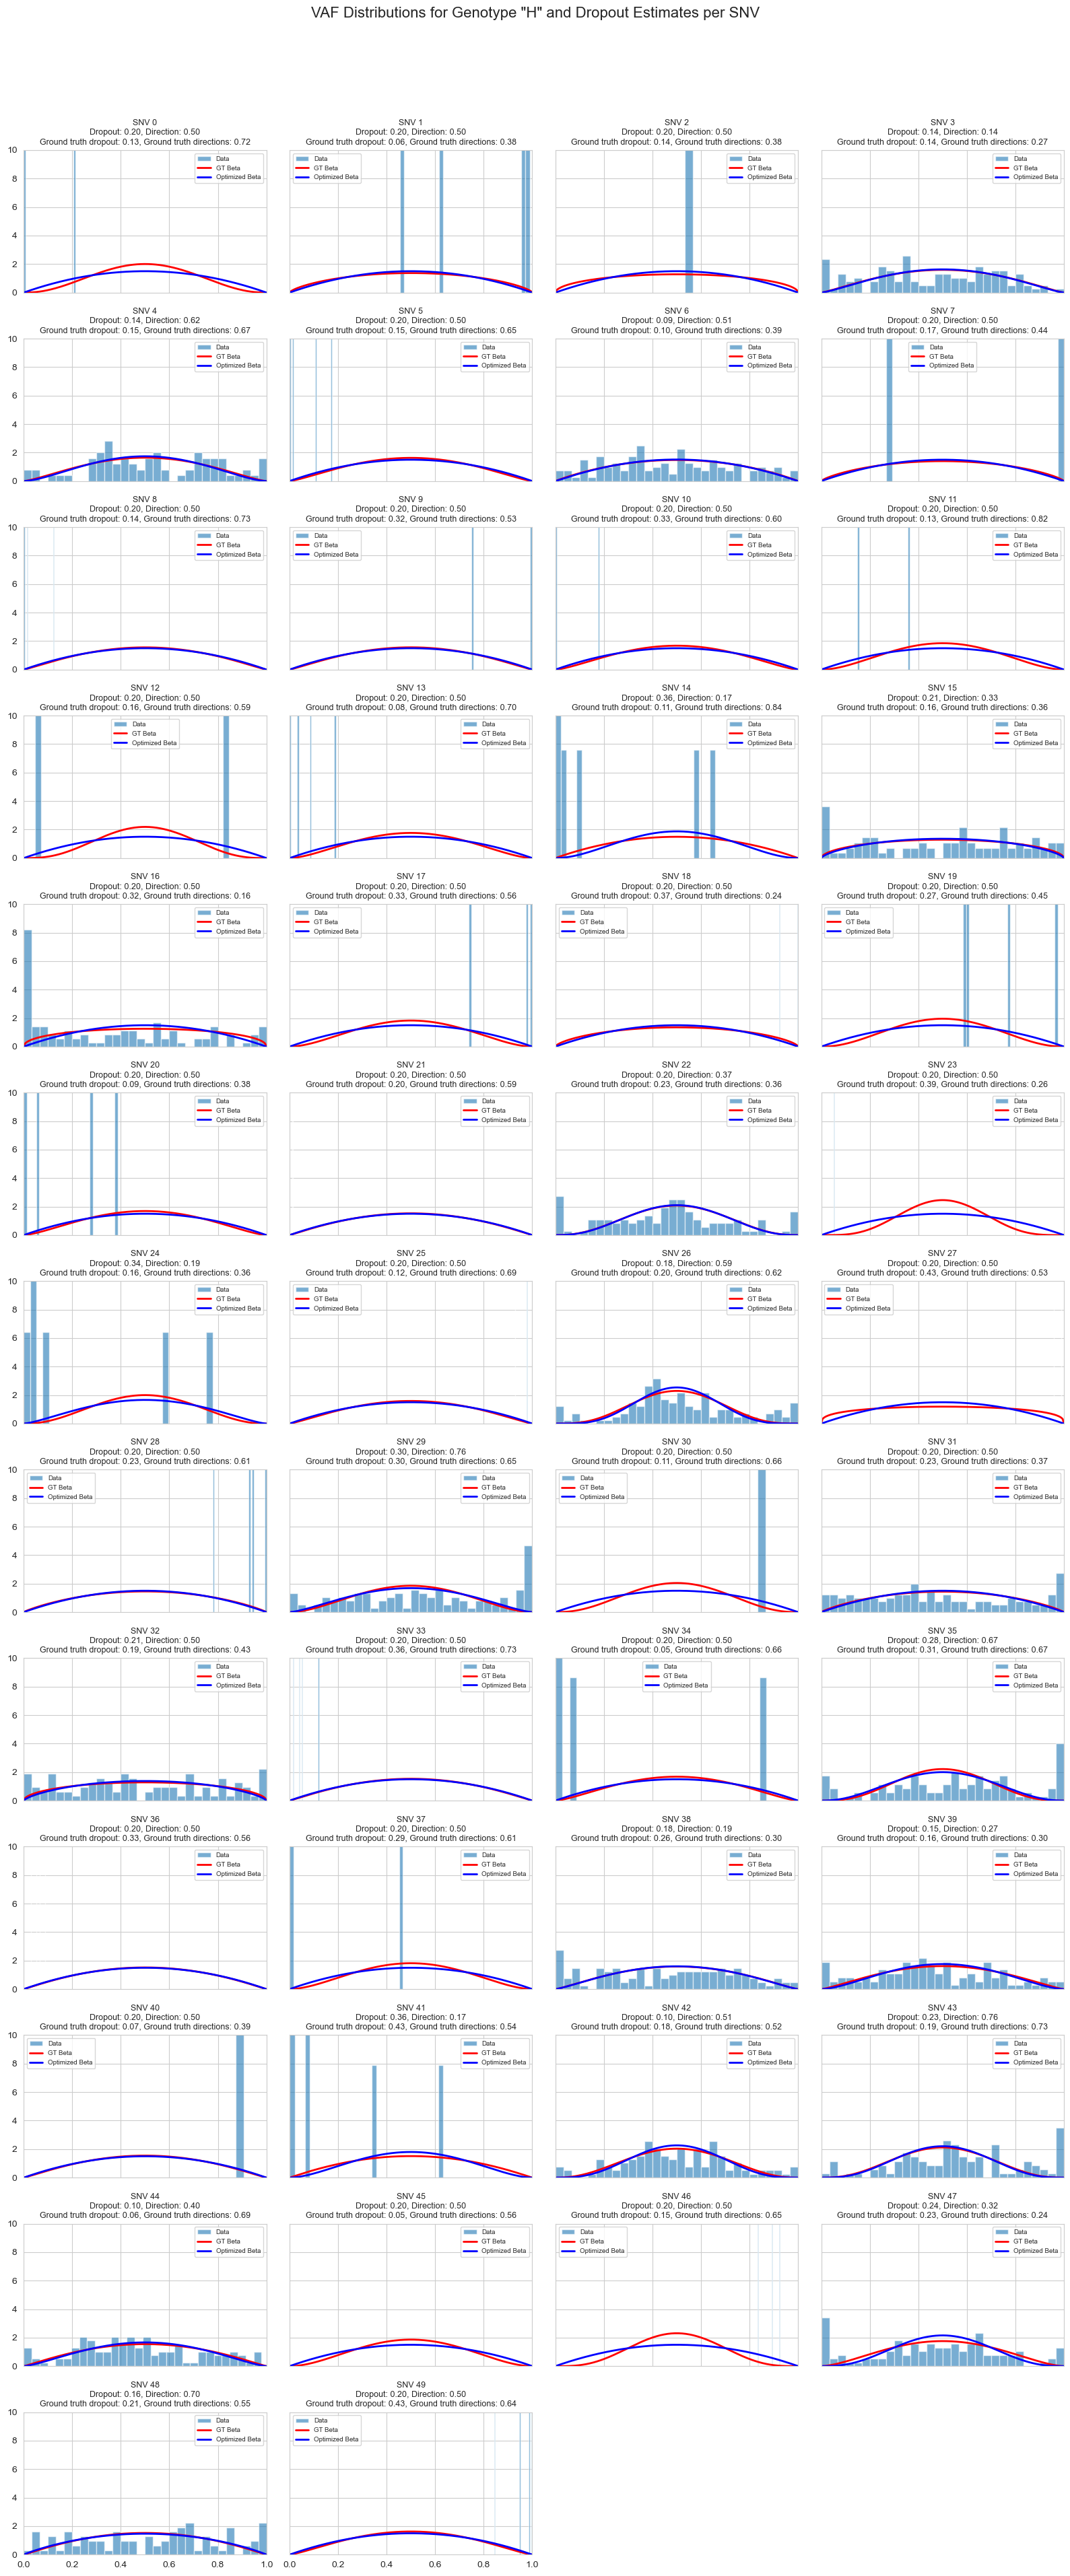

Posterior dropout probabilities (overall) per SNV:
[0.2, 0.2, 0.2, 0.13665297820726988, 0.13642606633322985, 0.2, 0.09166885471045301, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.36081690456597165, 0.20582847289508613, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.1964987962107187, 0.2, 0.3446230434023677, 0.2, 0.18027295350307299, 0.2, 0.2, 0.29871158937379144, 0.2, 0.2, 0.2071533411637622, 0.2, 0.2, 0.2789492534373496, 0.2, 0.2, 0.1806140060664246, 0.15483359446374695, 0.2, 0.35699483201513826, 0.1036525022064917, 0.22518502316504202, 0.09776838269475809, 0.2, 0.2, 0.2392921250896205, 0.15988944117486814, 0.2]
Posterior dropout direction probabilities per SNV:
[0.5, 0.5, 0.5, 0.1441965174528904, 0.6221617233991894, 0.5, 0.5089855208494695, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.17463209643865749, 0.33437941405650085, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.37103808124269094, 0.5, 0.19146952951065013, 0.5, 0.5925568027140609, 0.5, 0.5, 0.758536139407195, 0.5, 0.5, 0.4989525212879775, 0.5, 0.5, 0.6671969449623776, 0

In [65]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta


num_snvs = genotype.shape[1]

# Set up subplots (e.g. 4 columns per row)
ncols = 4
nrows = int(np.ceil(num_snvs / ncols))
fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), sharex=True, sharey=True)
axs = axs.flatten()

# x-axis values for plotting the Beta PDF
x_vals = np.linspace(0, 1, 200)

# Define global prior parameters for dropout probability and dropout direction.
# These priors represent our initial belief (as pseudo-counts) before observing any data.
alpha_dropout_prior = 2    # For overall dropout probability
beta_dropout_prior = 8     # (Thus prior dropout probability is 2/(2+8)=0.2)
alpha_direction_prior = 2  # For dropout direction (e.g., probability of alternate dropout)
beta_direction_prior = 2   # (Uniform prior)

# Containers to store per-SNV estimated dropout probabilities
dropout_probs_est = []         # Overall dropout probability
dropout_direction_probs_est = []  # Dropout direction probability (e.g., probability that dropout is alt)

for snv in range(num_snvs):
    # For the current SNV, get alt and ref read counts (for all cells)
    alt_snv = alt[:, snv]
    ref_snv = ref[:, snv]
    total = alt_snv + ref_snv

    # Compute VAF: defined as alt/(alt+ref) when total > 0; otherwise assign NaN
    with np.errstate(divide='ignore', invalid='ignore'):
        vaf = np.where(total > 0, alt_snv / total, np.nan)
    
    # Select only the cells with genotype "H" and valid VAF (i.e. total > 0)
    mask = (total > 10) & (genotype[:, snv] == 'H')
    vaf_H = vaf[mask]
    
    ax = axs[snv]
    
    # Plot the histogram for VAFs from cells with genotype "H" if there is data
    if vaf_H.size > 0:
        n_hist, bins, patches = ax.hist(vaf_H, bins=30, density=True, alpha=0.6, label='Data')
        max_hist = n_hist.max()
    else:
        max_hist = 0

    # Plot the ground truth Beta distribution for this SNV using alphas_H_gt and betas_H_gt
    alpha_gt = alphas_H_gt[snv]
    beta_gt = betas_H_gt[snv]
    pdf_gt = beta.pdf(x_vals, alpha_gt, beta_gt)
    ax.plot(x_vals, pdf_gt, 'r-', lw=2, label='GT Beta')

    # Skip completely uncovered sites (total_reads == 0)
    informative = (total > 10) & (genotype[:, snv] == 'H')
    alt_het = alt_snv[informative].astype(int)
    total_reads = total[informative].astype(int)

    if len(total_reads) > 5:
        individual_params = fit_parameters_individual(
            alt_het, total_reads, 10, 0.05,
            initial_params=[0.2, 0.5, 4])
    else:
        individual_params = 0.2, 0.5, 4

    posterior_dropout_prob, posterior_dropout_direction_prob, posterior_overdispersion_hs = individual_params
    dropout_probs_est.append(posterior_dropout_prob)
    dropout_direction_probs_est.append(posterior_dropout_direction_prob)
    
    posterior_alpha_hs = 0.5 * posterior_overdispersion_hs
    posterior_beta_hs = posterior_overdispersion_hs - posterior_alpha_hs
    pdf_gt = beta.pdf(x_vals, posterior_alpha_hs, posterior_beta_hs)
    ax.plot(x_vals, pdf_gt, 'b-', lw=2, label='Optimized Beta')

    
    # ----- Adjust the subplot and add info -----
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 10)
    # plt.yscale('log')
    
    # Add title with both dropout estimates
    ax.set_title(f"SNV {snv}\nDropout: {posterior_dropout_prob:.2f}, Direction: {posterior_dropout_direction_prob:.2f}\nGround truth dropout: {dropout_probs_gt[snv]:.2f}, Ground truth directions: {dropout_directions_gt[snv]:.2f}", fontsize=9)
    ax.legend(fontsize=7)

# Hide any unused subplots
for j in range(num_snvs, len(axs)):
    axs[j].axis('off')

plt.suptitle('VAF Distributions for Genotype "H" and Dropout Estimates per SNV', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Optionally, print the dropout estimates for all SNVs:
print("Posterior dropout probabilities (overall) per SNV:")
print(dropout_probs_est)
print("Posterior dropout direction probabilities per SNV:")
print(dropout_direction_probs_est)

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta


num_snvs = genotype_gt.shape[1]

# Set up subplots (e.g. 4 columns per row)
ncols = 4
nrows = int(np.ceil(num_snvs / ncols))
fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), sharex=True, sharey=True)
axs = axs.flatten()

# x-axis values for plotting the Beta PDF
x_vals = np.linspace(0, 1, 200)

# Define global prior parameters for dropout probability and dropout direction.
# These priors represent our initial belief (as pseudo-counts) before observing any data.
alpha_dropout_prior = 2    # For overall dropout probability
beta_dropout_prior = 8     # (Thus prior dropout probability is 2/(2+8)=0.2)
alpha_direction_prior = 2  # For dropout direction (e.g., probability of alternate dropout)
beta_direction_prior = 2   # (Uniform prior)

# Containers to store per-SNV estimated dropout probabilities
dropout_probs_est = []         # Overall dropout probability
dropout_direction_probs_est = []  # Dropout direction probability (e.g., probability that dropout is alt)

for snv in range(num_snvs):
    # For the current SNV, get alt and ref read counts (for all cells)
    alt_snv = alt[:, snv]
    ref_snv = ref[:, snv]
    total = alt_snv + ref_snv

    # Compute VAF: defined as alt/(alt+ref) when total > 0; otherwise assign NaN
    with np.errstate(divide='ignore', invalid='ignore'):
        vaf = np.where(total > 0, alt_snv / total, np.nan)
    
    # Select only the cells with genotype "H" and valid VAF (i.e. total > 0)
    mask = (total > 50) & (genotype[:, snv] == 'H')
    vaf_H = vaf[mask]
    
    ax = axs[snv]
    
    # Plot the histogram for VAFs from cells with genotype "H" if there is data
    if vaf_H.size > 0:
        n_hist, bins, patches = ax.hist(vaf_H, bins=30, density=True, alpha=0.6, label='Data')
        max_hist = n_hist.max()
    else:
        max_hist = 0

    # Plot the ground truth Beta distribution for this SNV using alphas_H_gt and betas_H_gt
    alpha_gt = alphas_H_gt[snv]
    beta_gt = betas_H_gt[snv]
    pdf_gt = beta.pdf(x_vals, alpha_gt, beta_gt)
    ax.plot(x_vals, pdf_gt, 'r-', lw=2, label='GT Beta')
    
    # ----- Estimate Dropout Parameters -----
    # Here, we assume a dropout is indicated by an extreme VAF.
    # A cell is considered to have a reference dropout if its VAF < 0.01,
    # and an alternate dropout if its VAF > 0.99.
    # We'll compute these counts using only the informative (genotype "H") cells.
    
    ref_dropouts = np.sum(vaf_H < 0.08)   # Reference dropout: ref allele disappeared
    alt_dropouts = np.sum(vaf_H > 0.92)   # Alternate dropout: alt allele disappeared
    total_dropouts = ref_dropouts + alt_dropouts
    total_informative = len(vaf_H)         # Total informative sites (cells) for genotype H

    # Update Beta priors to get posterior estimates (conjugate update):
    # For overall dropout probability:
    posterior_alpha_dropout = alpha_dropout_prior + total_dropouts
    posterior_beta_dropout = beta_dropout_prior + (total_informative - total_dropouts)
    # For dropout direction (if a dropout occurs, probability it is alt dropout):
    posterior_alpha_direction = alpha_direction_prior + alt_dropouts
    posterior_beta_direction = beta_direction_prior + ref_dropouts

    # Compute posterior means:
    posterior_dropout_prob = posterior_alpha_dropout / (posterior_alpha_dropout + posterior_beta_dropout)
    posterior_dropout_direction_prob = posterior_alpha_direction / (posterior_alpha_direction + posterior_beta_direction)
    
    # Store these estimates for later use or inspection
    dropout_probs_est.append(posterior_dropout_prob)
    dropout_direction_probs_est.append(posterior_dropout_direction_prob)
    
    # ----- Adjust the subplot and add info -----
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 10)
    # plt.yscale('log')
    
    # Add title with both dropout estimates
    ax.set_title(f"SNV {snv}\nDropout: {posterior_dropout_prob:.2f}, Direction: {posterior_dropout_direction_prob:.2f}\nGround truth dropout: {dropout_probs_gt[snv]:.2f}, Ground truth directions: {dropout_directions_gt[snv]:.2f}", fontsize=9)
    ax.legend(fontsize=7)

# Hide any unused subplots
for j in range(num_snvs, len(axs)):
    axs[j].axis('off')

plt.suptitle('VAF Distributions for Genotype "H" and Dropout Estimates per SNV', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Optionally, print the dropout estimates for all SNVs:
print("Posterior dropout probabilities (overall) per SNV:")
print(dropout_probs_est)
print("Posterior dropout direction probabilities per SNV:")
print(dropout_direction_probs_est)

In [ ]:
snv=29
alt_snv = alt[:, snv]
ref_snv = ref[:, snv]
total = alt_snv + ref_snv

# Compute VAF: defined as alt/(alt+ref) when total > 0; otherwise assign NaN
with np.errstate(divide='ignore', invalid='ignore'):
    vaf = np.where(total > 0, alt_snv / total, np.nan)

# Select only the cells with genotype "H" and valid VAF (i.e. total > 0)
mask = (total > 50) & (genotype_gt[:, snv] == 'H')
vaf_H = vaf[mask]

In [ ]:
import numpy as np
from scipy.stats import beta
from scipy.optimize import differential_evolution

# Constants
n = 10000

# Initial Beta prior parameters (can tune these)
alpha_no_dropout = 2
beta_no_dropout = 2
alpha_dropout_error = 0.5
beta_dropout_error = 9.5

# Dropout probabilities (these might change based on updated posteriors)
dropout_direction_probability = 0.5
dropout_probability = 0.2

# Cutoff space to search over
cutoff_values = np.linspace(0, 1, 1000)

# Convergence criteria
tolerance = 1e-3
max_iterations = 10

# Initialize cutoff (could also initialize to a guess like 0.08/0.92)
cutoff_low = 0.08
cutoff_high = 0.92

plt.hist(vaf_H, bins=30)
# plt.show()

# Loss function
def dropout_loss(cutoffs, all_vafs, true_dropout_rate, true_direction_probability):
    cutoff_low, cutoff_high = cutoffs

    low_bin = all_vafs[all_vafs < cutoff_low]
    high_bin = all_vafs[all_vafs > cutoff_high]
    total_count = len(all_vafs)

    # Estimated dropout stats
    estimated_dropout_rate = (len(low_bin) + len(high_bin)) / total_count
    if len(low_bin) + len(high_bin) == 0:
        estimated_direction_probability = 0.5
    else:
        estimated_direction_probability = len(high_bin) / (len(low_bin) + len(high_bin))

    # Squared error loss
    loss = ((estimated_dropout_rate - true_dropout_rate)**2 +
            (estimated_direction_probability - true_direction_probability)**2)

    return loss

for iteration in range(max_iterations):
    print(f"Iteration: {iteration}", alpha_no_dropout, beta_no_dropout, dropout_probability, dropout_direction_probability)
    
    # Generate beta samples from current posterior estimates
    no_dropout_dist = beta.rvs(alpha_no_dropout, beta_no_dropout, size=n)
    n_dropout = int(n * dropout_probability)
    dropout_dist_low = beta.rvs(alpha_dropout_error, beta_dropout_error, size=int(n_dropout * (1 - dropout_direction_probability)))
    dropout_dist_high = beta.rvs(beta_dropout_error, alpha_dropout_error, size=int(n_dropout * dropout_direction_probability))
    
    all_vafs = np.concatenate([no_dropout_dist, dropout_dist_low, dropout_dist_high])
    # plt.hist(all_vafs, bins=30, alpha=0.3)
    # plt.show()
    
    bounds = [(0.0, 0.1), (0.9, 1.0)]
    result = differential_evolution(dropout_loss, bounds,args=(all_vafs, dropout_probability, dropout_direction_probability), maxiter=100, tol=1e-5)
    
    # Extract results
    cutoff_low_new, cutoff_high_new = result.x


    # Use new cutoffs to compute dropouts from actual VAF data
    ref_dropouts = np.sum(vaf_H < cutoff_low_new)
    alt_dropouts = np.sum(vaf_H > cutoff_high_new)
    no_dropouts = vaf_H[(vaf_H >= cutoff_low_new) & (vaf_H <= cutoff_high_new)]
    total_dropouts = ref_dropouts + alt_dropouts
    total_informative = len(vaf_H)

    # Update posteriors
    alpha_dropout = 2 + total_dropouts
    beta_dropout = 8 + (total_informative - total_dropouts)

    alpha_direction = 2 + alt_dropouts
    beta_direction = 2 + ref_dropouts

    dropout_probability = alpha_dropout / (alpha_dropout + beta_dropout)
    dropout_direction_probability = alpha_direction / (alpha_direction + beta_direction)
    
    prior_samples = np.random.beta(alpha_no_dropout, beta_no_dropout, size=8)
    if len(no_dropouts) > 0:
        combined_samples = np.concatenate([prior_samples, no_dropouts])
        sample_mean = np.mean(combined_samples)
        sample_var = np.var(combined_samples, ddof=1)
    else:
        sample_var, sample_mean = 0, 1

    if sample_var != 0:
        # Method-of-moments estimation for Beta parameters
        common_term = sample_mean * (1 - sample_mean) / sample_var - 1
        alpha_no_dropout = sample_mean * common_term
        beta_no_dropout = (1 - sample_mean) * common_term

    if np.abs(cutoff_low_new - cutoff_low) < tolerance and np.abs(cutoff_high_new - cutoff_high) < tolerance:
        print(f"Converged after {iteration + 1} iterations.")
        break

    # Update cutoffs for next iteration
    cutoff_low = cutoff_low_new
    cutoff_high = cutoff_high_new

print(f"Optimized cutoffs: low = {cutoff_low:.4f}, high = {cutoff_high:.4f}")
print(f"Final dropout probability: {dropout_probability:.4f}")
print(f"Final dropout direction probability: {dropout_direction_probability:.4f}")

In [ ]:
from scipy.stats import beta

n= 10000
# Parameters for beta distributions
alpha_no_dropout = 2  # Alpha for no-dropout beta distribution
beta_no_dropout = 2    # Beta for no-dropout beta distribution
alpha_dropout = 9.5    # Alpha for dropout beta distribution
beta_dropout = 0.5     # Beta for dropout beta distribution

# Generate beta distributions
no_dropout_dist_beta = beta.rvs(alpha_no_dropout, beta_no_dropout, size=n)
dropout_dist_beta = beta.rvs(alpha_dropout, beta_dropout, size=n)

cutoff_values_beta = np.linspace(0, 1, 1000)

# Dropout probability
dropout_direction_probability = 0.5
dropout_probability = 0.2 * dropout_direction_probability

# Calculate the weighted FP and FN
weighted_fp_fn_diff_beta = np.abs(
    (1-dropout_probability) * (no_dropout_dist_beta[:, None] > cutoff_values_beta).sum(axis=0) -
    dropout_probability * (dropout_dist_beta[:, None] < cutoff_values_beta).sum(axis=0)
)

# Find the new cutoff
cutoff_beta_weighted = cutoff_values_beta[np.argmin(weighted_fp_fn_diff_beta)]

# Plot the new cutoff for beta distributions
plt.figure(figsize=(12, 6))
count, bins, ignored = plt.hist(no_dropout_dist_beta, bins=30, density=True, alpha=0.6, color='g', label='No Dropout (Beta)')
count, bins, ignored = plt.hist(dropout_dist_beta, bins=30, density=True, alpha=0.6, color='r', label='Dropout (Beta)')
plt.axvline(cutoff_beta_weighted, color='k', linestyle='--', linewidth=1, label=f'Cutoff: {cutoff_beta_weighted:.2f}')
plt.title('Beta Distributions and Cutoff Value (Weighted)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution

n = 10000

# Beta parameters
alpha_no_dropout = 2
beta_no_dropout = 2
alpha_dropout_low = 0.5
beta_dropout_low = 9.5
alpha_dropout_high = 9.5
beta_dropout_high = 0.5

# Dropout ground truth
dropout_direction_probability = 0.1
dropout_probability = 0.2

# Sample all distributions
no_dropout = beta.rvs(alpha_no_dropout, beta_no_dropout, size=n)
n_dropout = int(n * dropout_probability)
low_dropout = beta.rvs(alpha_dropout_low, beta_dropout_low, size=int(n_dropout * (1 - dropout_direction_probability)))
high_dropout = beta.rvs(alpha_dropout_high, beta_dropout_high, size=int(n_dropout * dropout_direction_probability))

# Combine all VAFs
all_vafs = np.concatenate([no_dropout, low_dropout, high_dropout])

# True values for optimization target
true_dropout_rate = dropout_probability
true_direction_probability = dropout_direction_probability

# Loss function
def dropout_loss(cutoffs):
    cutoff_low, cutoff_high = cutoffs

    low_bin = all_vafs[all_vafs < cutoff_low]
    high_bin = all_vafs[all_vafs > cutoff_high]
    total_count = len(all_vafs)

    # Estimated dropout stats
    estimated_dropout_rate = (len(low_bin) + len(high_bin)) / total_count
    if len(low_bin) + len(high_bin) == 0:
        estimated_direction_probability = 0.5
    else:
        estimated_direction_probability = len(high_bin) / (len(low_bin) + len(high_bin))

    # Squared error loss
    loss = ((estimated_dropout_rate - true_dropout_rate)**2 +
            (estimated_direction_probability - true_direction_probability)**2)

    return loss

# Use a global optimizer (differential evolution)
bounds = [(0.0, 0.5), (0.5, 1.0)]
result = differential_evolution(dropout_loss, bounds, maxiter=100, tol=1e-5)

# Extract results
cutoff_beta_low, cutoff_beta_high = result.x

# Final partition after optimization
low_bin = all_vafs[all_vafs < cutoff_beta_low]
high_bin = all_vafs[all_vafs > cutoff_beta_high]
middle_bin = all_vafs[(all_vafs >= cutoff_beta_low) & (all_vafs <= cutoff_beta_high)]

# Final recovered estimates
recovered_dropout_rate = (len(low_bin) + len(high_bin)) / len(all_vafs)
recovered_direction_probability = len(high_bin) / (len(low_bin) + len(high_bin))

# Plot
plt.figure(figsize=(12, 6))
plt.hist(no_dropout, bins=30, density=True, alpha=0.6, color='g', label='No Dropout')
plt.hist(low_dropout.tolist() + [1], bins=30, density=True, alpha=0.6, color='r', label='Low Dropout')
plt.hist(high_dropout.tolist() + [0], bins=30, density=True, alpha=0.6, color='b', label='High Dropout')
plt.axvline(cutoff_beta_low, color='purple', linestyle='--', linewidth=2, label=f'Low Cutoff: {cutoff_beta_low:.2f}')
plt.axvline(cutoff_beta_high, color='orange', linestyle='--', linewidth=2, label=f'High Cutoff: {cutoff_beta_high:.2f}')
plt.legend()
plt.grid(True)
plt.title("VAF Distributions and Optimized Cutoffs")
plt.show()

In [ ]:
# Final results
print(f"Optimized Low Cutoff: {cutoff_beta_low:.3f}")
print(f"Optimized High Cutoff: {cutoff_beta_high:.3f}")
print(f"Recovered Dropout Rate: {recovered_dropout_rate:.3f}")
print(f"Recovered Dropout Direction Probability: {recovered_direction_probability:.3f}")